In [1]:
import numpy as np
from scipy.stats import zscore
import scipy.sparse as sps
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pyglmnet as pyglmnet

In [3]:
model = pyglmnet.glm('binomial')

In [4]:
# Simulate data

# Dataset size
N = 20000
p = 1000

# Coefficients
beta0 = np.random.normal(0.0, 1.0, 1)
beta = sps.rand(p,1,0.01)
beta = np.array(beta.todense())

# Training data
xr = np.random.normal(0.0, 1.0, [N,p])
yr = model.simulate(beta0, beta, xr)

# Test data
xt = np.random.normal(0.0, 1.0, [N,p])
yt = model.simulate(beta0, beta, xt)


In [5]:
# Set regularization parameters
reg_lambda = np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1))
alpha = 0.8

fit_params = dict()
fit_params['reg_lambda'] = reg_lambda
fit_params['alpha'] = alpha

# Set optimization parameters
opt_params = dict()
opt_params['learning_rate'] = 1e-4
opt_params['max_iter'] = 1000

# Fit model to training data
fit = model.fit(zscore(xr),yr,fit_params,opt_params)


Lambda: 0.5

Converged
    Loss function: 13863.5497612
    dL/L: -0.00036455329613

Lambda: 0.323739401435

Converged
    Loss function: 13418.7752346
    dL/L: 0.000551299360402

Lambda: 0.209614400083

Converged
    Loss function: 12205.1044289
    dL/L: 0.000668579027145

Lambda: 0.13572088083

Converged
    Loss function: 11252.8078203
    dL/L: 0.000665571898604

Lambda: 0.087876393444

Converged
    Loss function: 10073.9604587
    dL/L: 0.000595618011409

Lambda: 0.0568981020276

Converged
    Loss function: 10189.36924
    dL/L: 0.000842105194347

Lambda: 0.0368403149864

Converged
    Loss function: 9858.80962423
    dL/L: -0.000451281326284

Lambda: 0.0238533230447

Converged
    Loss function: 9838.41245932
    dL/L: -0.000542094624737

Lambda: 0.0154445210495

Converged
    Loss function: 9791.66701664
    dL/L: -0.000662705435086

Lambda: 0.01

Converged
    Loss function: 9672.2410922
    dL/L: -0.000965017589125



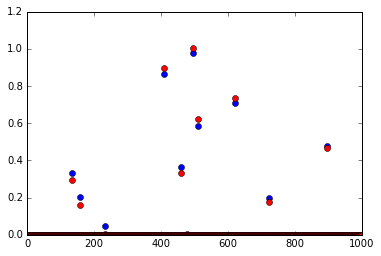

In [6]:
# Visualize estimated coefficients
fitparams = fit[-3]
plt.plot(beta[:], 'bo')
plt.hold(True)
plt.plot(fitparams['beta'][:], 'ro')
plt.show()

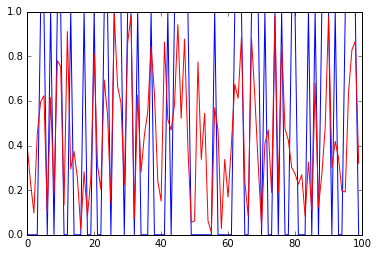

In [7]:
# Predict targets from test set

yrhat = model.lmb(fitparams['beta0'], fitparams['beta'], zscore(xr))
ythat = model.lmb(fitparams['beta0'], fitparams['beta'], zscore(xt))

plt.plot(yt[:100])
plt.hold(True)
plt.plot(ythat[:100], 'r')
plt.show()

In [8]:
# Compute pseudo-R2s
R2r = model.pseudo_R2(yr, yrhat, np.mean(yr))
R2t = model.pseudo_R2(yt, ythat, np.mean(yr))
print R2r, R2t

0.290278908178 0.291998569127
